In [3]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

In [4]:
import mplhep as hep
import mplhep.label as label_base
plt.style.use(hep.style.CMS)

In [5]:
inputlist = [
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5', 
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5' 
]

In [180]:
def get_mass_j1sdb_j2sdb(in_file):

    f_bb = pd.read_hdf(in_file)
    dt = f_bb.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])


    correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
    dt = dt[correct]
    correct = (dt[:,3]>100)
    dt = dt[correct]

    correct = (dt[:,19]>20)
    dt = dt[correct]

    correct = (dt[:,0]>=2800)
    dt = dt[correct]

    bsmlike = np.where(dt[:,16]>0.9)[0]
    dt = dt[bsmlike]
    
    addmask = np.where((dt[:,16]>0.90) )[0]
    #dt = dt[addmask]
    j1sdb = dt[:,3]*dt[:,16]
    j2sdb = dt[:,19]*dt[:,32]

    return dt[:,0], j1sdb, j2sdb, addmask

In [181]:
mjj, j1sdb1, j2sdb1, mask = get_mass_j1sdb_j2sdb(inputlist[0])
mjj_bkg , j1sdb1_bkg, j2sdb1_bkg, mask_bkg = get_mass_j1sdb_j2sdb(inputlist[3])

In [182]:
len(mjj)

239348

In [183]:
ae_def = {'type': 'bkg',
 'trainon': 'purebkg',
 'features': 'tauDDTwithm1andm1minusm2',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [184]:
bkgloss2_bb = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb1.npy")
bkgloss2_bkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")


In [185]:
ae_def = {'type': 'bkg',
 'trainon': 'purebkg',
 'features': 'NoDDT_withm1andm1minusm2',
 'architecture': 'MAF',
 'selection': 'mjj_mj1_mj2_cut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z4f10'}

In [186]:
bkgloss_bb = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb1.npy")
bkgloss_bkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")


In [187]:
ae_def = {'type': 'sig',
 'trainon': '2prong',
 'features': 'noddtnomass',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut0p9',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z4f10'}

In [188]:
prong2loss_bb = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb1.npy")
prong2loss_bkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")


In [189]:
ae_def = {'type': 'sig',
 'trainon': '3prong',
 'features': 'tauDDTwithoutrawmass',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut0p9',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [190]:
prong3loss_bb = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb1.npy")
prong3loss_bkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")


In [191]:
masswindow1 = np.where((mjj>3200) & (mjj<3270))[0]

masswindow2 = np.where((mjj>3400) & (mjj<3500))[0]

masswindow3 = np.where((mjj>3750) & (mjj<3900))[0]

masswindow4 = np.where((mjj>4200) & (mjj<4400))[0]

masswindow5 = np.where((mjj>5300) & (mjj<7000))[0]

In [192]:
print(len(masswindow1),len(masswindow2),len(masswindow3),len(masswindow4),len(masswindow5))

13034 14172 12582 8509 5585


(0.0, 10.0)

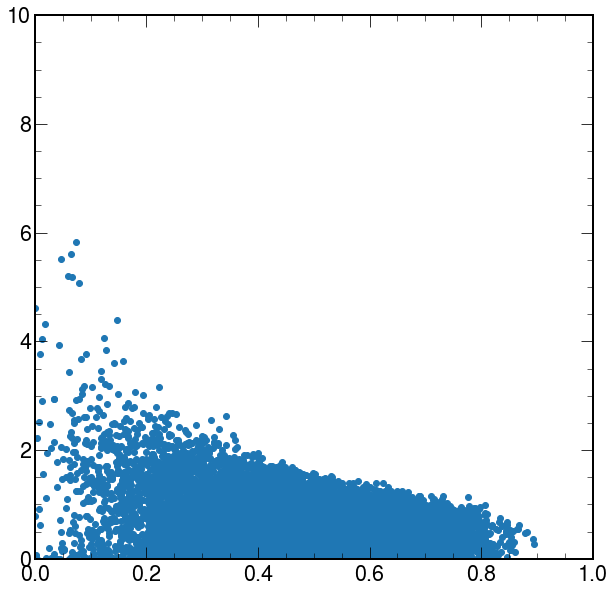

In [193]:
plt.scatter(np.exp(-bkgloss_bb[masswindow1]),np.exp(bkgloss_bb[masswindow1]-prong2loss_bb[masswindow1]));
plt.xlim([0,1])
plt.ylim([0,10])

In [194]:
plt.scatter(np.exp(-bkgloss_bb[masswindow2]),np.exp(bkgloss_bb[masswindow2]-sigloss_bb[masswindow2]));
plt.xlim([0,1])
plt.ylim([0,10])

NameError: name 'sigloss_bb' is not defined

(0.0, 10.0)

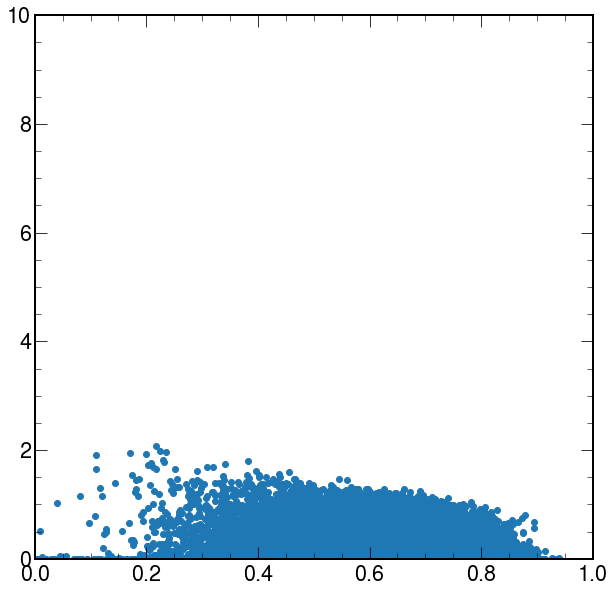

In [149]:
plt.scatter(np.exp(-bkgloss[masswindow3]),np.exp(bkgloss[masswindow3]-sigloss[masswindow3]));
plt.xlim([0,1])
plt.ylim([0,10])

(0.0, 10.0)

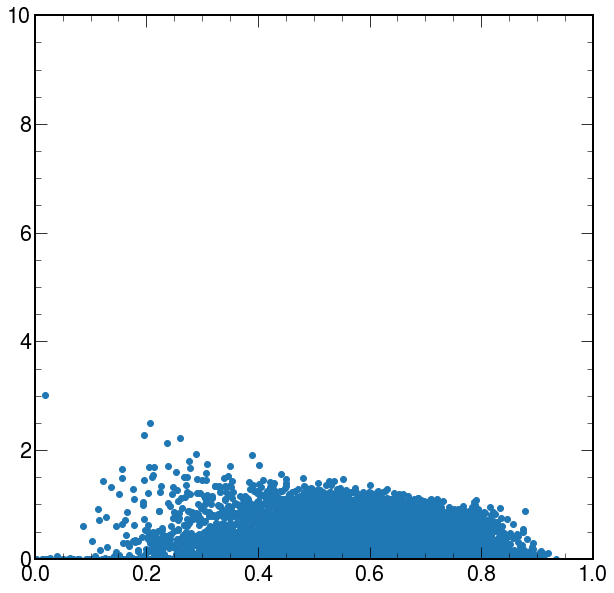

In [103]:
plt.scatter(np.exp(-bkgloss[masswindow4]),np.exp(bkgloss[masswindow4]-sigloss[masswindow4]));
plt.xlim([0,1])
plt.ylim([0,10])

(0.0, 10.0)

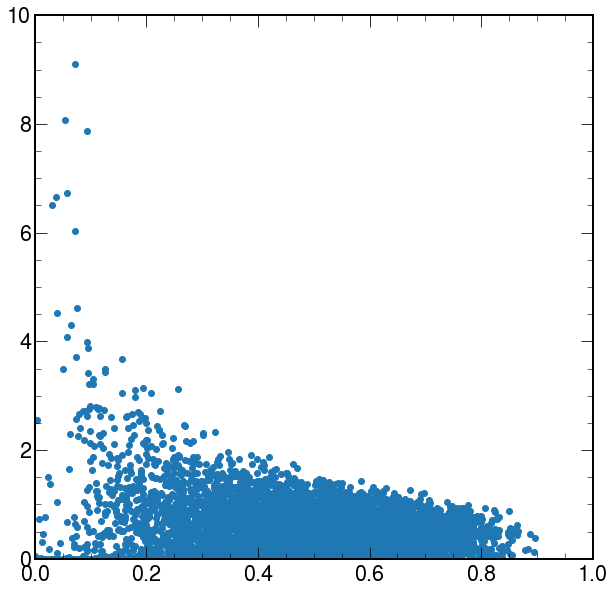

In [27]:
plt.scatter(np.exp(-bkgloss2_bb[masswindow5]),np.exp(bkgloss2_bb[masswindow5]-prong2loss_bb[masswindow5]));
plt.xlim([0,1])
plt.ylim([0,10])

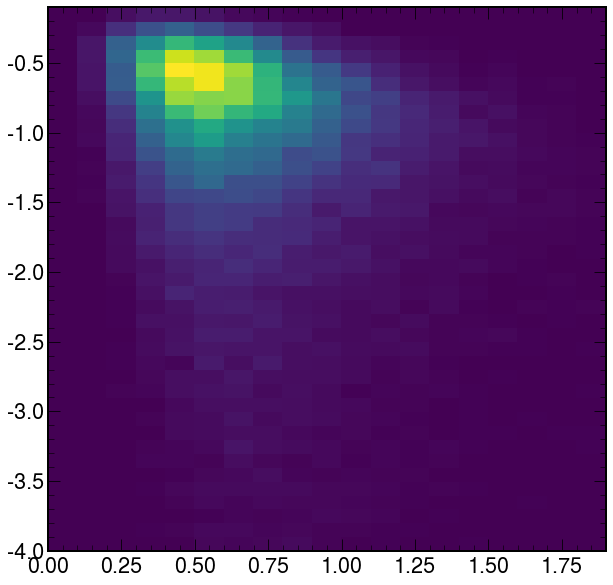

In [28]:
plt.hist2d(bkgloss_bb[masswindow],-prong2loss_bb[masswindow],bins=[np.arange(0,2,.1),np.arange(-4,0,.1)],density=True);

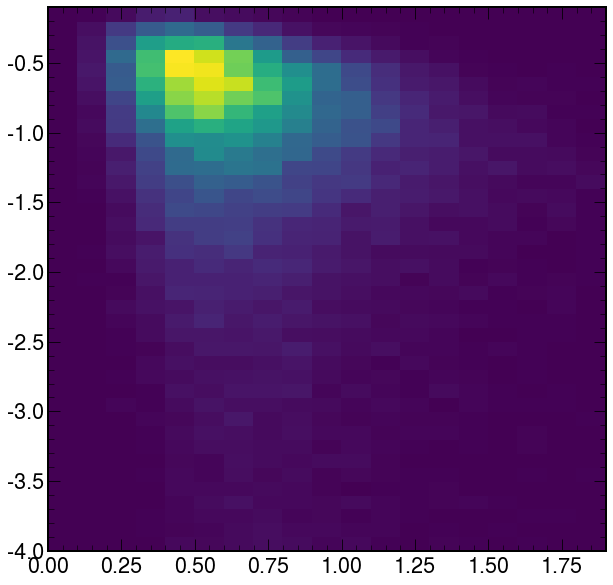

In [22]:
plt.hist2d(bkgloss_bb[masswindow2],-prong2loss_bb[masswindow2],bins=[np.arange(0,2,.1),np.arange(-4,0,.1)],density=True);

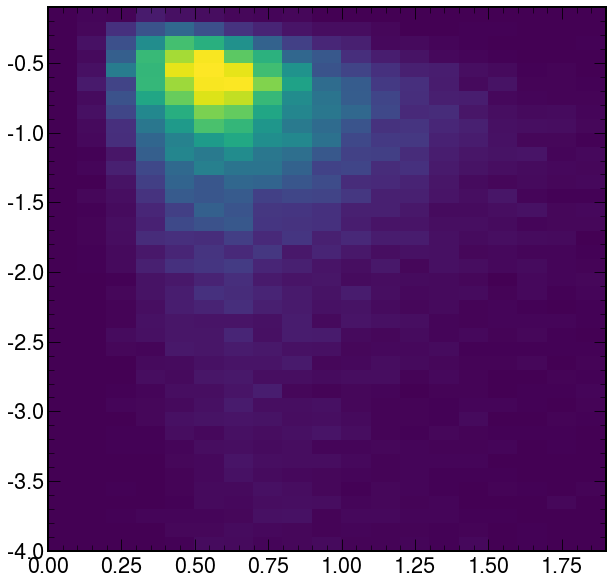

In [21]:
plt.hist2d(bkgloss_bb[masswindow3],-prong2loss_bb[masswindow3],bins=[np.arange(0,2,.1),np.arange(-4,0,.1)],density=True);

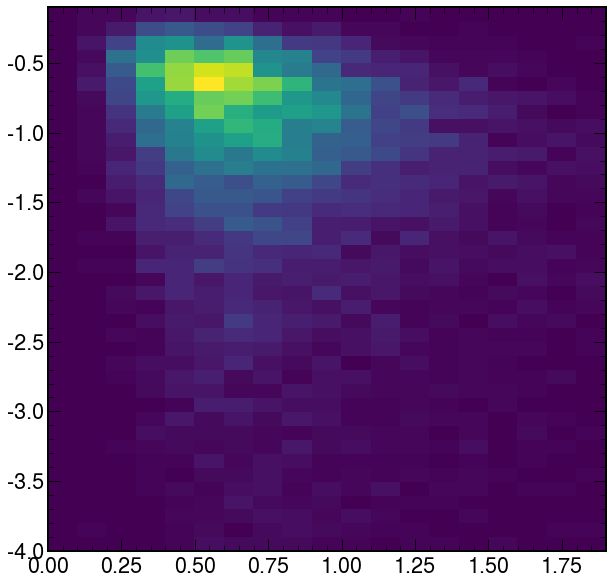

In [24]:
plt.hist2d(bkgloss_bb[masswindow4],-prong2loss_bb[masswindow4],bins=[np.arange(0,2,.1),np.arange(-4,0,.1)],density=True);

In [10]:
len(bkgloss_bb)

239348

In [11]:
len(prong2loss_bb)

239348

In [12]:
len(prong3loss_bb)

NameError: name 'prong3loss_bb' is not defined

In [28]:
bkgloss2_bb = bkgloss2_bb[mask]
bkgloss2_bkg = bkgloss2_bkg[mask_bkg]
bkgloss_bb = bkgloss_bb[mask]
bkgloss_bkg = bkgloss_bkg[mask_bkg]
prong2loss_bb = prong2loss_bb[mask]
prong2loss_bkg = prong2loss_bkg[mask_bkg]
prong3loss_bb = prong3loss_bb[mask]
prong3loss_bkg = prong3loss_bkg[mask_bkg]

In [29]:
len(bkgloss_bb)

239348

In [30]:
len(mjj)

239348

In [134]:
# BB 1  THAT WORKS
bbidx = np.where( (bkgloss_bb > 1.1) & (prong2loss_bb<.6)& (prong3loss_bb<100))[0]
#bkgidx = np.where( (bkgloss_bkg > 1.3) & (prong2loss_bkg<.8))[0]

In [135]:
len(bbidx)

1815

In [136]:
# BB 1  THAT WORKS
#bbidx = np.where((bkgloss_bb > 1.32) & (prong2loss_bb<.65))[0]
#bkgidx = np.where( (bkgloss_bkg > 1.32) & (prong2loss_bkg<.65))[0]

In [137]:
# BB 1 BEFORE
#bbidx = np.where( (bkgloss_bb > 1.3) & (prong2loss_bb<.9) & (prong3loss_bb<1))[0]
#bkgidx = np.where( (bkgloss_bkg > 1.3) & (prong2loss_bkg<.9) & (prong3loss_bkg<1))[0]

In [138]:
# BB 2 selection
#bbidx = np.where( (bkgloss_bb > 1.5) & (prong2loss_bb<.9) & (prong3loss_bb<.9))[0]
#bkgidx = np.where( (bkgloss_bkg > 1.5) & (prong2loss_bkg<.9) & (prong3loss_bkg<.9))[0]

In [139]:
# BB 3
#bbidx = np.where( (bkgloss_bb > 0.9) & (prong2loss_bb<1.) & (prong3loss_bb<1.))[0]
#bkgidx = np.where( (bkgloss_bkg > 0.9) & (prong2loss_bkg<1.) & (prong3loss_bkg<1.))[0]

In [140]:
#bbidx = np.where( (bkgloss_bb > 1.1) & (prong2loss_bb<1.0))[0]
#bkgidx = np.where( (bkgloss_bkg > 1.1) & (prong2loss_bkg<1.0))[0]

In [141]:
#print(len(bbidx==True),len(bkgidx))

(3000.0, 7000.0)

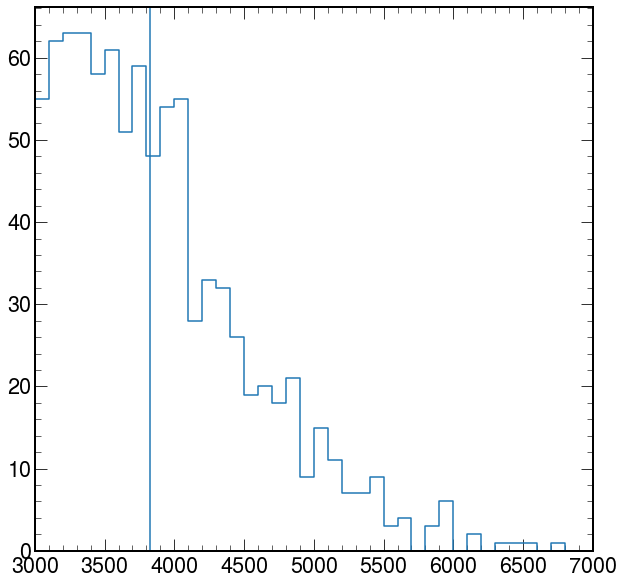

In [130]:
#bbidx = np.where( (bkgloss_bb > 1.1) & (prong2loss_bb<.6)& (prong3loss_bb<100))[0]
BBTYPE = 'Black Box 1'
#priorusage = '2prongprior'
#priorusage = '2prongprior_withtrimmedmasscutbyeyeball'
#priorusage = '3prongprior'
#priorusage = '3prongprior_withtrimmedmasscutbyeyeball_j1200j2600'
#priorusage = 'allprior'
priorusage = 'TESTING'
BBTYPE_FILENAME = 'BB1'
savedir = 'analysis'
#bbidx = np.where( (bkgloss_bb > 1.1) & (prong2loss_bb<.6)& (prong3loss_bb<100))[0]

h, bins = np.histogram(mjj[bbidx],bins=np.arange(2900,7000,100))
plt.axvline(x=3823)
hep.histplot(h, bins)
plt.xlim([3000,7000])

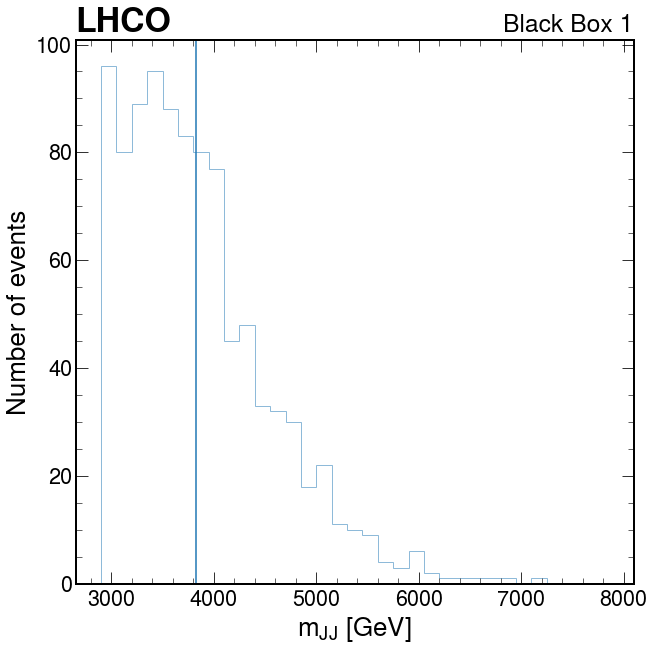

In [131]:
bins = np.arange(2900,8000,150)
obs_hist = plt.hist(mjj[bbidx],bins=bins,density=False,alpha=0.5,histtype='step')

sideband = j1sdb1[bbidx][((mjj[bbidx]<3670)&(mjj[bbidx]>3580)) | ((mjj[bbidx]<4100)&(mjj[bbidx]>3973))]
sigregion = j1sdb1[bbidx][((mjj[bbidx]<3973)&(mjj[bbidx]>3670))]

bkg_hist = plt.hist(sideband,bins=bins,weights=np.ones(len(sideband))*(len(mjj[bbidx])/len(sideband)) , density=False,alpha=0.2)

#plt.hist(mjj_bkg[bkgidx],bins=np.arange(2900,7000,200),density=True,alpha=0.5)
#sideband_left = plt.hist(mjj[bbidx][(j1sdb1[bbidx]<3600)&(j1sdb1[bbidx]>3400)])
#sideband_left = plt.hist(mjj[(bbidx)&(j1sdb1<4200)&(j1sdb1>4000)])
plt.axvline(x=3823)
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
#plt.yscale('log')
#plt.title('subplot 1')
#hep.cms.cmslabel(data=False, paper=False, year='2017')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.legend(loc='upper right')
#np.save('')
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_MJJ.png')
#print(a)

In [100]:
bins

array([2900, 3050, 3200, 3350, 3500, 3650, 3800, 3950, 4100, 4250, 4400,
       4550, 4700, 4850, 5000, 5150, 5300, 5450, 5600, 5750, 5900, 6050,
       6200, 6350, 6500, 6650, 6800, 6950, 7100, 7250, 7400, 7550, 7700,
       7850])

In [400]:
import ROOT as r

xlow, xhigh = bins[0],bins[-1]
BINS = len(bins)-1


roothist_obs = r.TH1F('data_obs','data_obs',BINS,xlow,xhigh)
roothist_bkg = r.TH1F('bkgestimate','bkgestimate',BINS,xlow,xhigh)

for i in range(0,BINS):
    roothist_obs.SetBinContent(i+1,obs_hist[0][i])
    roothist_bkg.SetBinContent(i+1,bkg_hist[0][i])
    #print(bkg_hist[0][i])

    
f = r.TFile.Open("../statistics/blackbox1.root",'recreate')
roothist_obs.Write()
roothist_bkg.Write()
f.Close()    

Warning in <TROOT::Append>: Replacing existing TH1: data_obs (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bkgestimate (Potential memory leak).


In [305]:
xhigh

7400

In [306]:
BINS

30

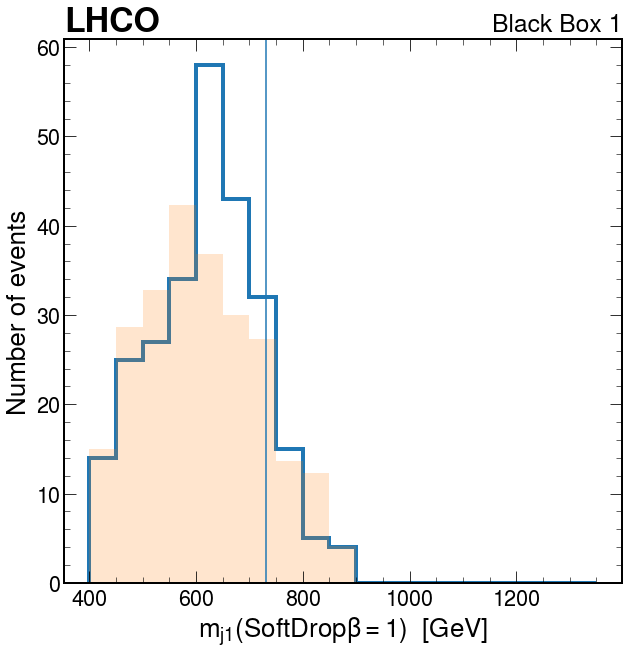

In [115]:
bins = np.arange(400,1400,50)


sideband = j1sdb1[bbidx][((mjj[bbidx]<3670)&(mjj[bbidx]>3580)) | ((mjj[bbidx]<4100)&(mjj[bbidx]>3973))]
sigregion = j1sdb1[bbidx][((mjj[bbidx]<3973)&(mjj[bbidx]>3670))]


plt.hist(sigregion,bins=bins,density=False,alpha=1,label='signal',histtype='step',linewidth=4)
plt.hist(sideband,bins=bins,density=False,weights=np.ones(len(sideband))*((len(sigregion))/(len(sideband))),alpha=0.2)


#b = plt.hist(j1sdb1_bkg[bkgidx],bins=np.arange(300,1400,50),density=True,alpha=0.3)
#print(a,b)
#c = np.max((a[0]-b[0],np.zeros(len(a[0]))),axis=0)
#bincenters = 0.5*(a[1][:-1]+a[1][1:])
#plt.plot(bincenters,c)
#print(c)
#print(a[1])
#plt.yscale('log')
plt.xlabel(r'$m_{j1}(SoftDrop \beta=1)$  [GeV]')
plt.ylabel('Number of events')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.axvline(x=732)

#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1sdb1.png')


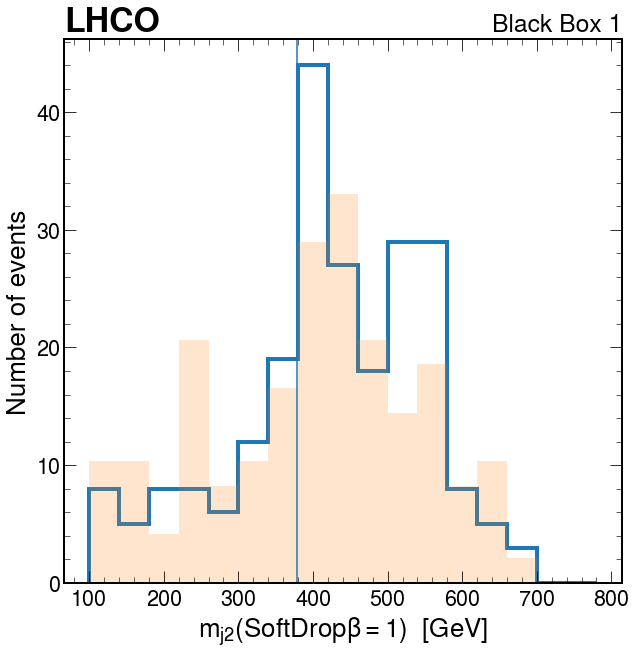

In [120]:
bins = np.arange(100,800,40)



sideband  = j2sdb1[bbidx][((mjj[bbidx]<3640)&(mjj[bbidx]>3580)) | ((mjj[bbidx]<4050)&(mjj[bbidx]>3973))]
sigregion = j2sdb1[bbidx][((mjj[bbidx]<3973)&(mjj[bbidx]>3670))]

plt.hist(sigregion,bins=bins,density=False,alpha=1,label='signal',histtype='step',linewidth=4)

plt.hist(sideband,bins=bins,density=False,weights=np.ones(len(sideband))*((len(sigregion))/(len(sideband))),alpha=0.2)

#b = plt.hist(j2sdb1_bkg[bkgidx],bins=np.arange(100,1200,40),density=True,alpha=0.3)
#c = np.max((a[0]-b[0],np.zeros(len(a[0]))),axis=0)
#bincenters = 0.5*(a[1][:-1]+a[1][1:])
#plt.plot(bincenters,c)
plt.xlabel(r'$m_{j2}(SoftDrop \beta=1)$  [GeV]')
plt.ylabel('Number of events')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.axvline(x=378)
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2trimmed.png')

In [179]:
dt = f_BB1.values

In [180]:
dt_rnd = f_rnd.values

In [181]:
correct = (dt[:,3]>0) &(dt[:,19]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
        
        
correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]

In [182]:

rnd_idx = dt_rnd[:,-1]
print(rnd_idx[:30])

correct = (dt_rnd[:,3]>0) &(dt_rnd[:,19]>0)
dt_rnd = dt_rnd[correct]
for i in range(13,19):
    dt_rnd[:,i] = dt_rnd[:,i]/dt_rnd[:,3]
    
for i in range(29,35):
    dt_rnd[:,i] = dt_rnd[:,i]/(dt_rnd[:,19])
        
        
correct = (dt_rnd[:,29]>=0) &(dt_rnd[:,29]<=1)&(dt_rnd[:,30]>=0) &(dt_rnd[:,30]<=1)&(dt_rnd[:,31]>=0) &(dt_rnd[:,31]<=1)&(dt_rnd[:,32]>=0) &(dt_rnd[:,32]<=1)&(dt_rnd[:,33]>=0) &(dt_rnd[:,33]<=1)&(dt_rnd[:,34]>=-0.01) &(dt_rnd[:,34]<=1)
dt_rnd = dt_rnd[correct]

rnd_idx = dt_rnd[:,-1]
print(rnd_idx[:30])
print(len(rnd_idx))
correct = np.where(rnd_idx == 0)[0]
print(len(correct))
dt_bkg = dt_rnd[correct]

[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]
1013459
938331


In [183]:
bb_mass = dt[:,0]
bb_j1trim = dt[:,3] * dt[:,13]
bb_j2trim = dt[:,19] * dt[:,29]

bb_j1sdb1 = dt[:,3] * dt[:,16]
bb_j2sdb1 = dt[:,19] * dt[:,32]

bb_j1raw = dt[:,3]

In [184]:
bkg_mass = dt_bkg[:,0]
bkg_j1trim = dt_bkg[:,3] * dt_bkg[:,13]
bkg_j2trim = dt_bkg[:,19] * dt_bkg[:,29]

bkg_j1sdb1 = dt_bkg[:,3] * dt_bkg[:,16]
bkg_j2sdb1 = dt_bkg[:,19] * dt_bkg[:,32]

bkg_j1raw = dt_bkg[:,3]

In [185]:
#dt_rnd = f_rnd.values
#rnd_idx = dt_rnd[:,-1]

In [186]:
#improve purity of trainig by only selecting properly reconstructed jets 

# APPLY PRESELECTION BEFORE DOING THE FIT TO THE LDA

In [187]:
def generate_X(whichsample):
    #bkgloss_0 = np.load(f'../data_strings/bkgae_rndbkg_loss_{whichsample}.npy')
    bkgloss_1 = np.load(f'../data_strings/bkgae_purebkg_withmass_turnonselection_Huberloss_beta1_WAICloss_{whichsample}.npy')
    sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_5tausMasRatioNoRawMass_turnonselection_MSELoss_beta1_z6f8_Justloss_{whichsample}.npy')
    #sigaeloss_1 = np.load(f'../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta1_WAICloss_{whichsample}.npy')
    sigaeloss_1 = np.load(f'../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta0p1_WAICloss_{whichsample}.npy')
    bkgloss_1[bkgloss_1 > 1e6 ] = 1e6
    sigaeloss_0[sigaeloss_0 > 1e6 ] = 1e6
    sigaeloss_1[sigaeloss_1 > 1e6 ] = 1e6
    
    #print(np.max(bkgloss_0))
    print(np.max(bkgloss_1))
    print(np.max(sigaeloss_0))
    print(np.max(sigaeloss_1))
    
    print(len(bkgloss_1))
    
    
    return np.column_stack((bkgloss_1,sigaeloss_0,sigaeloss_1))

In [190]:
BB1 = generate_X('bb1')

1000000.0
13511.104
20021.203
914617


In [191]:
BKG = generate_X('rndbkg')

1000000.0
15482.961
22914.14
938331


(0.0, 200.0)

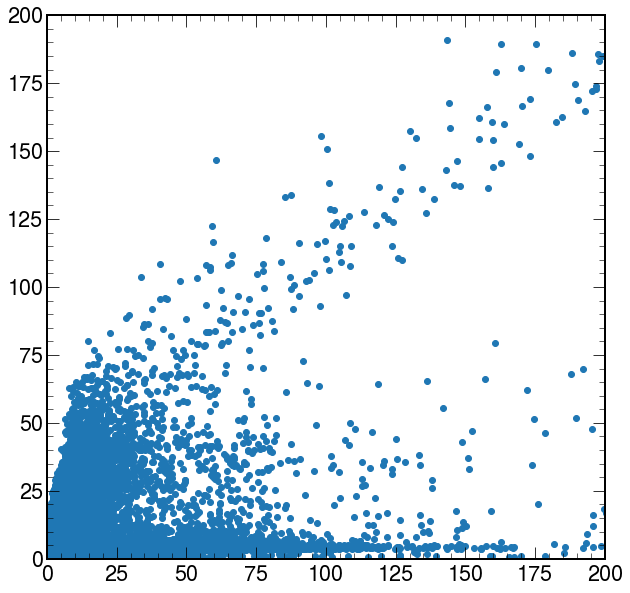

In [192]:
plt.scatter(BB1[:100000,0],BB1[:100000,1])
plt.xlim([0,200])
plt.ylim([0,200])

In [193]:
len(BB1[:,0])

914617

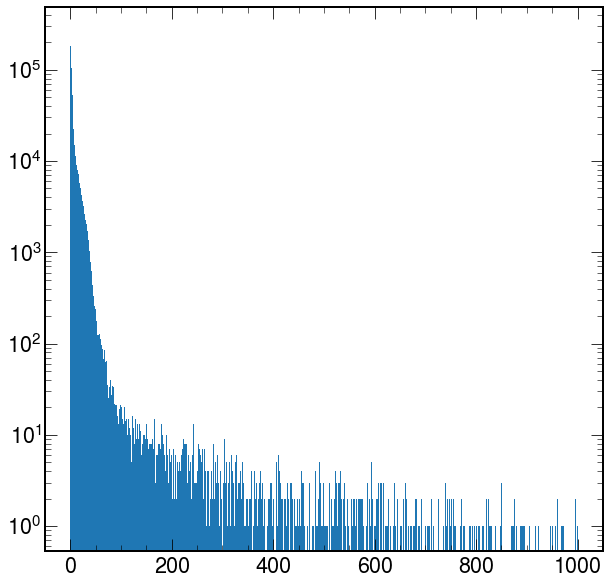

In [194]:
plt.hist(BB1[:,1],bins=np.linspace(0,1000,1000));
#plt.xscale('log')
plt.yscale('log')

# BLACK BOX 1

In [195]:
#bb1_index = np.where((BB1[:,0]>23) & (BB1[:,1]<1.5) & ((dt[:,13]>0.9)) & ((dt[:,0]>4000)) )[0]
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0)   & ((dt[:,0]<5000)) & ((dt[:,0]>3500)))[0]


#####BB1 default cut #####
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0)  )[0]


##### BB1 with 3 prong prior
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,2]<.8)  )[0]

### BB1 with both prior

#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0) & (BB1[:,2]<.8)  )[0]

# BLACK BOX 2

In [232]:
###### BB Testing
bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<.5)   )[0]
bkg_index = np.where((BKG[:,0]>15) & (BKG[:,1]<.5)   )[0]

In [233]:
#####BB2 2prong prior #####
#bb1_index = np.where((BB1[:,0]>8.6) & (BB1[:,1]<0.5)  )[0]
       # 2prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.1) & (bb_j2trim> 200) &(bb_j1trim>600))[0]

#####BB2 3 prong prior
#bb1_index = np.where((BB1[:,0]>10.3) & (BB1[:,2]<.5)  )[0]
     #3prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>8) & (BB1[:,2]<1.5)  & (bb_j2trim> 200) &(bb_j1trim>600) )[0]

###### BB2 with both prior
# bb1_index = np.where((BB1[:,0]>16) & (BB1[:,1]<1.3) & (BB1[:,2]<0.8)   )[0]
# bkg_index = np.where((BKG[:,0]>16) & (BKG[:,1]<1.3) & (BKG[:,2]<0.8)   )[0]
#both prior, masstrim
#bb1_index = np.where((BB1[:,0]>12) & (BB1[:,1]<1) & (BB1[:,2]<1) & (bb_j2trim> 200)  )[0]

# Black Box 3

In [234]:
#####BB3 2prong prior #####
#bb1_index = np.where((BB1[:,0]>6) & (BB1[:,1]<.8)  )[0]
       # 2prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>6) & (BB1[:,1]<1.1) & (bb_j1trim> 500) &(bb_j2trim>200))[0]

#####BB3 3 prong prior

#bb1_index = np.where((BB1[:,0]>8) & (BB1[:,2]<.6)  )[0]
     #3prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>1) & (BB1[:,2]<.6)  & (bb_j1trim> 600) &(bb_j2trim>200) )[0]

###### BB3 with both prior
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.3) & (BB1[:,2]<1.3))[0]
        #allprior with tau cut on jet 1
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.3) & (BB1[:,2]<1.3) & (dt[:,5]>0.4) )[0]

In [235]:
#bb1_index = np.where((BB1[:,0]>4.) & ((dt[:,13]>0.6)))[0]

In [236]:
print(len(bb1_index),len(bkg_index))

453 163


In [237]:
BBTYPE = 'Black Box 1'
#priorusage = '2prongprior'
#priorusage = '2prongprior_withtrimmedmasscutbyeyeball'
#priorusage = '3prongprior'
#priorusage = '3prongprior_withtrimmedmasscutbyeyeball_j1200j2600'
#priorusage = 'allprior'
priorusage = 'TEST'
BBTYPE_FILENAME = 'BB1'
savedir = 'plots'

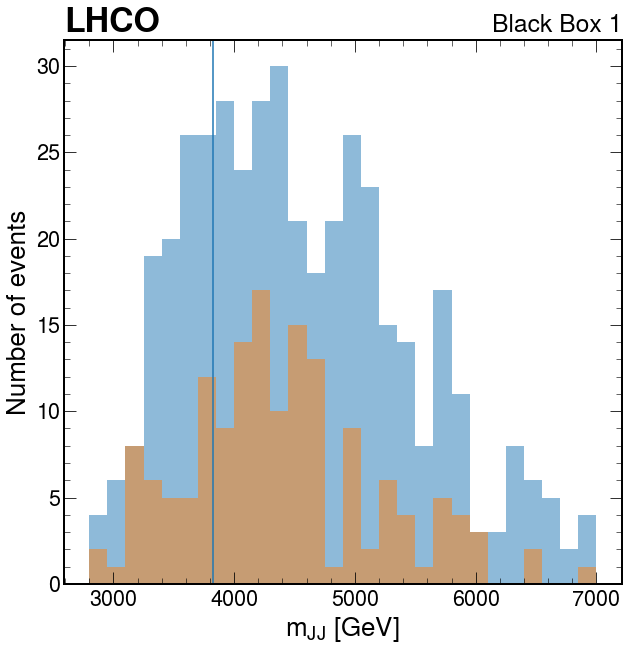

In [239]:
plt.hist(bb_mass[bb1_index],bins=np.linspace(2800,7000,29),alpha=0.5)
plt.hist(bkg_mass[bkg_index],bins=np.linspace(2800,7000,29),alpha=0.5)

plt.axvline(x=3823)
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
#plt.title('subplot 1')
#hep.cms.cmslabel(data=False, paper=False, year='2017')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.legend(loc='upper right')
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_MJJ.png')
#print(a)

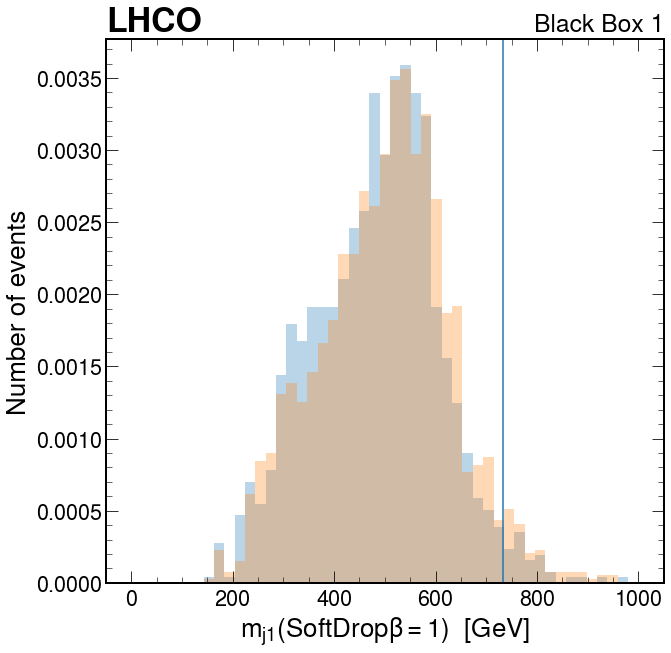

In [177]:
plt.hist(bb_j1sdb1[bb1_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)
plt.hist(bkg_j1sdb1[bkg_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)

plt.xlabel(r'$m_{j1}(SoftDrop \beta=1)$  [GeV]')
plt.ylabel('Number of events')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.axvline(x=732)
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1trimmed.png')


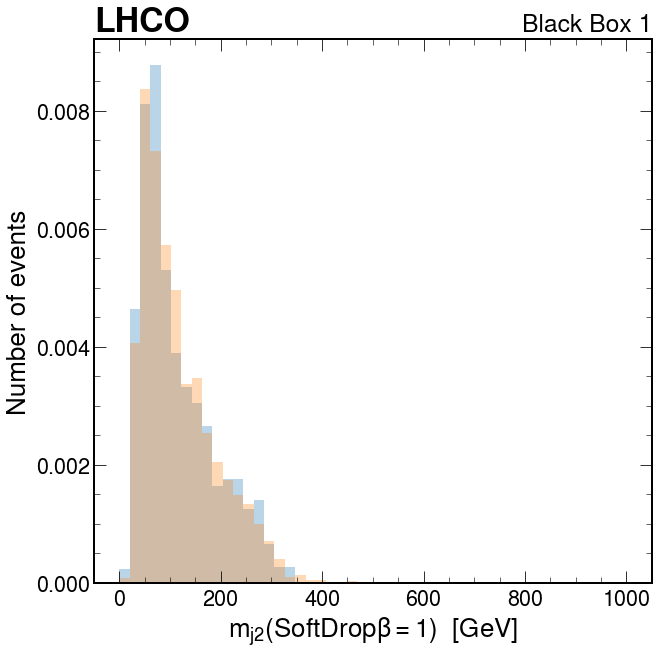

In [178]:
plt.hist(bb_j2sdb1[bb1_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)
plt.hist(bkg_j2sdb1[bkg_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)

plt.xlabel(r'$m_{j2}(SoftDrop \beta=1)$  [GeV]')
plt.ylabel('Number of events')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.axvline(x=378)
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2trimmed.png')


In [ ]:
plt.hist(dt[bb1_index,4],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,4],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper right')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet1\ \tau_{21}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1tau21.png')



In [ ]:
plt.hist(dt[bb1_index,5],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,5],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')

hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet1\ \tau_{32}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1tau32.png')


In [ ]:
plt.hist(dt[bb1_index,20],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,20],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet2\ \tau_{21}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2tau21.png')

In [ ]:
plt.hist(dt[bb1_index,21],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,21],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet2\ \tau_{32}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2tau32.png')

In [ ]:
from scipy.stats import percentileofscore

In [ ]:
percentiles = [percentileofscore(BB1[:,2], i) for i in BB1[:,2]]

In [ ]:
plt.scatter(BB1[:,0],BB1_prob[:,1])
plt.xscale('log')

In [ ]:
def get_loss(X):
    